In [1]:
!conda install -y gdown

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          36 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.1-pyhd8ed1a

In [160]:
import gdown
# url = https://drive.google.com/uc?id=1A9bri4EiNv2Q-g4QisMr63Ve0YQIxCpZ
!gdown --id 1muHqhO8aEQlTc1Xrlg46JgyBZeS4kJ3R

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1muHqhO8aEQlTc1Xrlg46JgyBZeS4kJ3R
From (redirected): https://drive.usercontent.google.com/download?id=1muHqhO8aEQlTc1Xrlg46JgyBZeS4kJ3R&confirm=t&uuid=1704083d-787c-4b0b-a10c-28bdffb05d65
To: /kaggle/working/dakshina_dataset_v1.0.tar
100%|███████████████████████████████████████| 2.01G/2.01G [00:08<00:00, 229MB/s]


In [161]:
! tar -xf dakshina_dataset_v1.0.tar
! rm dakshina_dataset_v1.0.tar
! rm seq2seq_new.pth

In [162]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
from unidecode import unidecode
import unicodedata

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [163]:
# input = English
# output = Devanagari

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

lang = "hi"
fp = open(f'/kaggle/working/dakshina_dataset_v1.0/{lang}/lexicons/{lang}.translit.sampled.train.tsv',"r")
# print(fp.readline())
file_contents = fp.read().splitlines()
file_contents_updated = []
pairs = []
for content in file_contents:
    content = re.sub('\s+', ',', content)
    file_contents_updated.append(content)

for list_ele in file_contents_updated:
    devanagari, latin , value = list_ele.split(',')
    devanagari = devanagari.lower()
    latin = latin.lower()
    pairs.append([latin, devanagari]) # swap here if  you want y= f(X) in another direction

print("Toatl number of elements : ", len(pairs)) # English , Hindi -> Present in Correct format
for latin, devan in pairs:
    #append tokens to each output text
    devan = "\t" + devan + "\n"
    input_texts.append(latin)
    target_texts.append(devan)
    # add the characters to the set
    for char in latin:
        if char not in input_characters:
            input_characters.add(char)
    for char in devan:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters)) # stores each unique input characters
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters) # number of unique input characters
num_decoder_tokens = len(target_characters)

# find the the max size of input and target string 
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # maximum possible length of input word
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens) # input characters len
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length) 
print("Max sequence length for outputs:", max_decoder_seq_length) 

# create a dictonary that maps input with the keywords
input_token_index = dict([(char, idx) for idx, char in enumerate(input_characters)])
output_token_index = dict([(char, idx) for idx, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), # 4502, 15, 26
    dtype="float32",
)

# for decoder input
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
# for decoder output target
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

# encode the data into one-hot vectors
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, output_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, output_token_index[char]] = 1.0
            
print("Enocoder/Decoder length : ", len(encoder_input_data), " , ", len(decoder_input_data), " , ", len(decoder_target_data))

Toatl number of elements :  44204
Number of samples: 44204
Number of unique input tokens: 26
Number of unique output tokens: 65
Max sequence length for inputs: 20
Max sequence length for outputs: 21
Enocoder/Decoder length :  44204  ,  44204  ,  44204


In [164]:
class Seq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, hidden_size, num_layers):
        super(Seq2SeqModel, self).__init__()

        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.encoder = nn.RNN(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        print("Embeddde dim : ", embedding_dim, "Hidden size : ", hidden_size)
        self.decoder = nn.RNN(embedding_dim + hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_vocab_size)
        print("Model init success")
    def forward(self, input_sequence, target_sequence):
        # Encode input sequence
#         print("1")
        embedded_input = self.embedding(input_sequence)
#         print("Input seq type : ",type(input_sequence),input_sequence.shape, " , Embedded input type : " ,type(embedded_input),embedded_input.shape )
#         print("2")
        _, hidden_state = self.encoder(embedded_input)
#         print("hidden_state  type : ",type(hidden_state),hidden_state.shape )
#         print("3")
        # Decode target sequence
        embedded_target = self.embedding(target_sequence)

        decoder_input_last_hidden_end = torch.cat([embedded_target.unsqueeze(1).expand(-1,2,-1,-1), hidden_state.permute(1, 0, 2).unsqueeze(2).repeat(1, 1, target_sequence.size(1), 1)], dim=-1)
        decoder_input_last_hidden_end = decoder_input_last_hidden_end[:,0,:,:]

        output, _ = self.decoder(decoder_input_last_hidden_end)

        output = self.fc(output)

#         print("Modelling success")
        return output

In [165]:
def train(model, encoder_input_data, decoder_target_data, criterion, optimizer, epochs):
    
    training_error = []

    encoder_input_data = torch.from_numpy(encoder_input_data).long()
    decoder_target_data = torch.from_numpy(decoder_target_data).long()

    encoder_input_data = pad_sequence([torch.Tensor(seq) for seq in encoder_input_data], batch_first=True)
    decoder_target_data = pad_sequence([torch.Tensor(seq) for seq in decoder_target_data], batch_first=True)

    # Convert to GPU if available
    encoder_input_data = encoder_input_data.to(device)
    decoder_target_data = decoder_target_data.to(device)
    
    train_dataset = TensorDataset(encoder_input_data, decoder_target_data)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    input_token_index_rev = {v:k for k,v in input_token_index.items()}
    output_token_index_rev = {v:k for k,v in output_token_index.items()}
    print(len(train_loader))
    i = 0
    for epoch in range(epochs):
        total_loss = 0.0
        
        for input_seq, target_seq in zip(encoder_input_data, decoder_target_data):
            prev_idx = 0
            
            input_seq = torch.cat([input_seq, input_seq[-1].unsqueeze(0)], dim=0)

            optimizer.zero_grad()

            # torch.set_printoptions(threshold=10_000) # To print huge data
            _, input_indices = torch.max(input_seq, 1)
            gt = ''.join([input_token_index_rev[idx] for idx in input_indices.squeeze().tolist()])

            _, target_indices = torch.max(target_seq, 1)
            gt_tar = ''.join([output_token_index_rev[idx] for idx in target_indices.squeeze().tolist()])
            gt_tar = gt_tar.strip()
            
            input_seq = input_seq.to(device) #Move the data into respective device using
            target_seq = target_seq.to(device)

            output = model(input_seq, target_seq)
            _, pred_indices = torch.max(output, 1)

            pred_string = ''
            for lst in pred_indices.squeeze().tolist():
                idx = max(lst)
                if idx == prev_idx:
                    break
                pred_string += output_token_index_rev[prev_idx]
                prev_idx = idx
            pred_string = pred_string.strip()

            loss = criterion(output.view(-1, output.size(2)), target_seq.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # print the result for every 10K words to check for convergence
            if (i%10000) == 0:
                training_error.append( total_loss/len(encoder_input_data))
                print(i, ", Padded Input : ", gt)
                print("target : ", gt_tar)
                print("Predicted : ",pred_string)
            i = i+1

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}, inp_len : {len(encoder_input_data)}, train_loader_len : {len(train_loader)}')

    print('size : ', len(training_error))
    # Plot the computed stats
    plt.plot(training_error, label='Training Loss', color='g')
    plt.xlabel('Steps(Each step = 10000)')
    plt.ylabel('Training loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Embeddde dim :  128 Hidden size :  256
Model init success
44204
0 , Padded Input :  anaaaaaaaaaaaaaaaaaaa
target :  अं
Predicted :  ऊईऋ
10000 , Padded Input :  ganwaanaaaaaaaaaaaaaa
target :  गंवाना
Predicted :  ङअषीफीं
20000 , Padded Input :  nightaaaaaaaaaaaaaaaa
target :  नाइट
Predicted :  फीउड
30000 , Padded Input :  marengeaaaaaaaaaaaaaa
target :  मरेंगे
Predicted :  वषौइछौअ
40000 , Padded Input :  sardaraaaaaaaaaaaaaaa
target :  सरदारा
Predicted :  िरदारा
Epoch 1/2, Loss: 0.00026491149166039886, inp_len : 44204, train_loader_len : 44204
50000 , Padded Input :  eyaraforsaaaaaaaaaaaa
target :  एयरफोर्स
Predicted :  औशषयोष्िअ
60000 , Padded Input :  thoonthaaaaaaaaaaaaaa
target :  ठूंठ
Predicted :  तूइठअ
70000 , Padded Input :  failaavaaaaaaaaaaaaaa
target :  फैलाव
Predicted :  फैलाव
80000 , Padded Input :  varnashramaaaaaaaaaaa
target :  वर्णाश्रम
Predicted :  वर्णाश्रम
Epoch 2/2, Loss: 0.0, inp_len : 44204, train_loader_len : 44204
size :  9


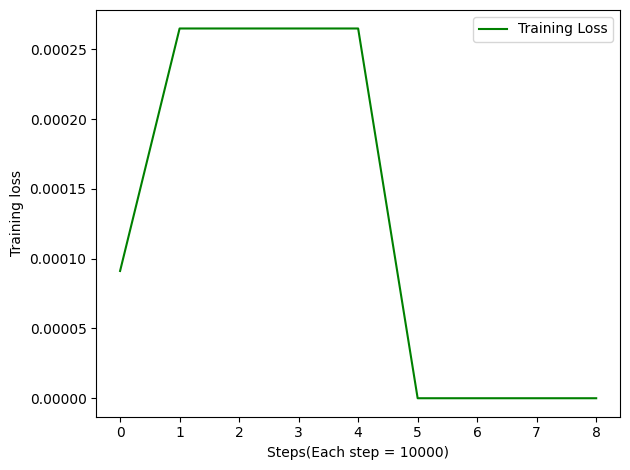

In [166]:
model = Seq2SeqModel(input_vocab_size = num_encoder_tokens, output_vocab_size = num_decoder_tokens, embedding_dim = 128, hidden_size = 256, num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, encoder_input_data, decoder_target_data, criterion, optimizer, epochs=2)

**As the training proceeds further and further we can see that the convergence of the algorithm i.e, the target string is equal to the output string**

In [10]:
PATH = './seq2seq_new.pth'
torch.save(model.state_dict(), PATH)

In [11]:
PATH = './seq2seq_new.pth'
# saved_model = 
saved_model = Seq2SeqModel(input_vocab_size = num_encoder_tokens, output_vocab_size = num_decoder_tokens, embedding_dim = 128, hidden_size = 256, num_layers = 2).to(device)
saved_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

Model init success


<All keys matched successfully>

**Verification**

In [12]:
# input = English
# output = Devanagari

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

lang = "hi"
fp = open(f'/kaggle/working/dakshina_dataset_v1.0/{lang}/lexicons/{lang}.translit.sampled.test.tsv',"r")
file_contents = fp.read().splitlines()
file_contents_updated = []
pairs = []
for content in file_contents:
    content = re.sub('\s+', ',', content)
    file_contents_updated.append(content)

for list_ele in file_contents_updated:
    devanagari, latin , value = list_ele.split(',')
    devanagari = devanagari.lower()
    latin = latin.lower()
    pairs.append([latin, devanagari]) # swap here if  you want y= f(X) in another direction

print("Toatl number of elements : ", len(pairs)) # English , Hindi -> Present in Correct format
for latin, devan in pairs:
    #append tokens to each output text
    devan = "\t" + devan + "\n"
    input_texts.append(latin)
    target_texts.append(devan)
    # add the characters to the set
    for char in latin:
        if char not in input_characters:
            input_characters.add(char)
    for char in devan:
        if char not in target_characters:
            target_characters.add(char)
            
input_characters = sorted(list(input_characters)) # stores each unique input characters
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters) # number of unique input characters
num_decoder_tokens = len(target_characters)

# find the the max size of input and target string 
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # maximum possible length of input word
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens) # input characters len
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length) 
print("Max sequence length for outputs:", max_decoder_seq_length) 

input_token_index = dict([(char, idx) for idx, char in enumerate(input_characters)])
output_token_index = dict([(char, idx) for idx, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), # 4502, 15, 26
    dtype="float32",
)
# for decoder input
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
# for decoder output target
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, output_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, output_token_index[char]] = 1.0

Toatl number of elements :  4502
Number of samples: 4502
Number of unique input tokens: 26
Number of unique output tokens: 63
Max sequence length for inputs: 16
Max sequence length for outputs: 17


In [13]:
def verify_translation(model, input_vocab, output_vocab, encoder_input_data, decoder_input_data, decoder_target_data):
    # reverse the ddictionary to verify the outputs to the given input
    input_vocab_rev = {v:k for k,v in input_vocab.items()}
    output_vocab_rev = {v:k for k,v in output_vocab.items()}
    
    #make the encoder and decoder input data to numpy long
    encoder_input_data = torch.from_numpy(encoder_input_data).long()
    decoder_target_data = torch.from_numpy(decoder_target_data).long()
    decoder_input_data = torch.from_numpy(decoder_input_data).long()
    
    model.eval()
    count = 0
    correct = 0
    
    print("The input data is padded with 'a' so that there is an appearance of a's at the end of the input string\n")
        
    for input_seq, target_seq in (zip(encoder_input_data, decoder_target_data)):
        loss_sum = 0.0
        input_seq = torch.cat([input_seq, input_seq[-1].unsqueeze(0)], dim=0)
        input_seq = input_seq.to(device)  # Move input to GPU
        target_seq = target_seq.to(device)  # Move target to GPU
        #torch.set_printoptions(threshold=10_000)
        _, input_indices = torch.max(input_seq, 1)
        gt = ''.join([input_vocab_rev[idx] for idx in input_indices.squeeze().tolist()])
        # print("Input : ", gt)
        
        _, target_indices = torch.max(target_seq, 1)
        gt_tar = ''.join([output_vocab_rev[idx] for idx in target_indices.squeeze().tolist()])
        gt_tar = gt_tar.strip()
        #print("Target : ", gt_tar, "length : ", len(gt_tar))

        output = model(input_seq, target_seq)
        loss = criterion(output.view(-1, output.size(2)), target_seq.view(-1))
                
        predictions = F.softmax(output, dim=1)
        predicted_values, predicted_indices = torch.max(predictions, 1)
        prev_idx = 0
        idx = 0
        # empty output string
        pred_string = ''
        for lst in predicted_indices.squeeze().tolist():
            idx = max(lst)
            if idx == prev_idx:
                break
            pred_string += output_vocab_rev[prev_idx]
            prev_idx = idx
        pred_string = pred_string.strip()

        if pred_string == gt_tar:
            correct += 1

        count += 1
        if (count % 500) == 0.0:
            print("\nPadded Input data: ", gt)
            print("Target: ", gt_tar)
            print("Output : ", pred_string)
    print("correct : ", correct, "count : ", count)
    print("Accuracy  : ", (100*correct)//count)
    
verify_translation(saved_model,  input_token_index, output_token_index, encoder_input_data, decoder_input_data, decoder_target_data)

The input data is padded with 'a' so that there is an appearance of a's at the end of the input string


Padded Input data:  umanathaaaaaaaaaa
Target:  उमानाथ
Output :  उमानाथ

Padded Input data:  girijagharonaaaaa
Target:  गिरजाघरों
Output :  गिरजाघरों

Padded Input data:  taooaaaaaaaaaaaaa
Target:  टाऊ
Output :  टाऊ

Padded Input data:  nazraaneaaaaaaaaa
Target:  नजराने
Output :  नजराने

Padded Input data:  praathmikataaaaaa
Target:  प्राथमिकता
Output :  प्राथमिकता

Padded Input data:  bhuliaaaaaaaaaaaa
Target:  भूली
Output :  भूली

Padded Input data:  resheaaaaaaaaaaaa
Target:  रेशे
Output :  रेशे

Padded Input data:  samprabhutaaaaaaa
Target:  संप्रभुता
Output :  संप्रभुता

Padded Input data:  hoshangabadaaaaaa
Target:  होशंगाबाद
Output :  होशंगाबाद
correct :  4455 count :  4502
Accuracy  :  98
